In [1]:
%%capture 
!pip install pandas numpy matplotlib seaborn scipy plotly ipython openpyxl --quiet

In [2]:
import json
import pickle
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.subplots
import scipy.stats as stats
import seaborn as sns
from IPython.display import display

pd.options.display.max_columns = None

sns.set_theme()
sns.set_context("notebook", font_scale=0.8) 

%config InlineBackend.figure_format = 'retina'  
%config InlineBackend.print_figure_kwargs = {'dpi': 170}  

In [3]:
data_dir = Path("./Data")
output_dir = Path('Output')
output_dir.mkdir(exist_ok=True)

### Clembench

In [4]:
clemrun_dir = Path('/Users/nidhirbhavsar/Desktop/WORK/Clembench/clembench-runs/')

In [5]:
clemb = pd.read_csv(clemrun_dir / 'v1.6' / 'results.csv')
clemb = clemb.rename(columns={clemb.columns[0]: 'models'})

In [6]:
score_col = clemb.columns[1]
played_col = clemb.columns[2]
quality_col = clemb.columns[3]

In [7]:
clemb.models = clemb.models.apply(lambda x: re.sub(r'(\w*)-t0.0.*', r'\1', x).lower())

In [8]:
clemb = clemb.set_index('models')

In [9]:
clemb = clemb[~clemb.index.str.contains('anyscale')].copy(deep=True)
clemb.index = clemb.index.map(lambda x: re.sub(r'meta-(\w*)', r'\1', x))
clemb.index = clemb.index.map(lambda x: re.sub(r'(\w*)-hf', r'\1', x))

In [10]:
clemb.head()

-, clemscore  all, Average % Played  \
models                                                                 
codellama-34b-instruct                  14.35                  33.57   
llama-3.1-nemotron-70b-instruct         10.16                  20.76   
llama-3-70b-instruct                    35.11                  80.72   
llama-3-8b-instruct                     19.99                  76.10   
llama-3.1-405b-instruct-turbo           52.11                  90.12   

                                 all, Average Quality Score  \
models                                                        
codellama-34b-instruct                                42.76   
llama-3.1-nemotron-70b-instruct                       48.92   
llama-3-70b-instruct                                  43.50   
llama-3-8b-instruct                                   26.27   
llama-3.1-405b-instruct-turbo                         57.82   

                                 imagegame, % Played  \
models                                                 
codellama-34b-instruct                           0.0   
llama-3.1-nemotron-70b-instruct                  0.0   
llama-3-70b-instruct                             0.0   
llama-3-8b-instruct                              0.0   
llama-3.1-405b-instruct-turbo                   62.5   

                                 imagegame, Quality Score  \
models                                                      
codellama-34b-instruct                                NaN   
llama-3.1-nemotron-70b-instruct                       NaN   
llama-3-70b-instruct                                  NaN   
llama-3-8b-instruct                                   NaN   
llama-3.1-405b-instruct-turbo                       94.12   

                                 imagegame, Quality Score (std)  \
models                                                            
codellama-34b-instruct                                      NaN   
llama-3.1-nemotron-70b-instruct                             NaN   
llama-3-70b-instruct                                        NaN   
llama-3-8b-instruct                                         NaN   
llama-3.1-405b-instruct-turbo                             12.55   

                                 privateshared, % Played  \
models                                                     
codellama-34b-instruct                               0.0   
llama-3.1-nemotron-70b-instruct                     92.0   
llama-3-70b-instruct                               100.0   
llama-3-8b-instruct                                 96.0   
llama-3.1-405b-instruct-turbo                      100.0   

                                 privateshared, Quality Score  \
models                                                          
codellama-34b-instruct                                    NaN   
llama-3.1-nemotron-70b-instruct                         78.85   
llama-3-70b-instruct                                    84.37   
llama-3-8b-instruct                                     58.91   
llama-3.1-405b-instruct-turbo                           84.24   

                                 privateshared, Quality Score (std)  \
models                                                                
codellama-34b-instruct                                          NaN   
llama-3.1-nemotron-70b-instruct                               15.63   
llama-3-70b-instruct                                          13.69   
llama-3-8b-instruct                                           30.05   
llama-3.1-405b-instruct-turbo                                 29.65   

                                 referencegame, % Played  \
models                                                     
codellama-34b-instruct                             100.0   
llama-3.1-nemotron-70b-instruct                     30.0   
llama-3-70b-instruct                               100.0   
llama-3-8b-instruct                                100.0   
llama-3.1-405b-instruct-turbo                      100.0   


In [11]:
clemb_model_rankings = clemb['-, clemscore'].rank(ascending=False)
clemb_model_rankings

models
codellama-34b-instruct             40.0
llama-3.1-nemotron-70b-instruct    51.0
llama-3-70b-instruct               14.0
llama-3-8b-instruct                30.0
llama-3.1-405b-instruct-turbo       5.0
                                   ... 
sheep-duck-llama-2-13b             63.0
sheep-duck-llama-2-70b-v1.1        29.0
tulu-2-dpo-70b                     46.0
vicuna-13b-v1.5                    57.0
vicuna-33b-v1.3                    50.0
Name: -, clemscore, Length: 72, dtype: float64

### Chatbot Arena

Load the latest elo_results_*.pkl from [Link](https://huggingface.co/spaces/lmarena-ai/chatbot-arena-leaderboard/tree/main)

In [12]:
!curl -L -o Data/elo_results_20241205.pkl https://huggingface.co/spaces/lmarena-ai/chatbot-arena-leaderboard/resolve/main/elo_results_20241205.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1123  100  1123    0     0   6263      0 --:--:-- --:--:-- --:--:--  6273
100 4646k  100 4646k    0     0  3480k      0  0:00:01  0:00:01 --:--:-- 5973k


In [13]:
elo_file = data_dir / 'elo_results_20241205.pkl'

with open(elo_file, 'rb') as file:
    cba_data = pickle.load(file)

In [14]:
cba_lead = cba_data['text']['full']['leaderboard_table_df']

In [15]:
cba_lead = cba_lead.sort_values(by='rating', ascending=False)
arena_models = cba_lead.index.tolist()
# arena_rankings = [[name, index+1] for index, name in enumerate(arena_models)]

In [16]:
cba_lead

rating   variance  rating_q975  rating_q025  \
gemini-exp-1206             1379.381608  17.565464  1389.261175  1374.089996   
chatgpt-4o-latest-20241120  1365.989211   6.218036  1370.263680  1361.144941   
gemini-exp-1121             1364.166861   6.712222  1368.516799  1358.857629   
gemini-exp-1114             1346.712582   4.880862  1350.138761  1342.312892   
chatgpt-4o-latest-20240903  1339.227686   3.233887  1342.608334  1335.999706   
...                                 ...        ...          ...          ...   
chatglm-6b                   879.059432  20.977356   887.262661   871.169535   
fastchat-t5-3b               867.719062  23.615523   878.460725   858.536615   
stablelm-tuned-alpha-7b      840.089460  22.668306   850.221230   831.112492   
dolly-v2-12b                 821.972947  38.159392   833.714432   807.914568   
llama-13b                    799.350698  47.740976   812.487726   784.827178   

                            num_battles  final_ranking  
gemini-exp-1206                    5052              1  
chatgpt-4o-latest-20241120        21929              2  
gemini-exp-1121                   15004              2  
gemini-exp-1114                   16872              5  
chatgpt-4o-latest-20240903        48958              6  
...                                 ...            ...  
chatglm-6b                         4993            215  
fastchat-t5-3b                     4302            216  
stablelm-tuned-alpha-7b            3341            218  
dolly-v2-12b                       3485            218  
llama-13b                          2445            219  

[173 rows x 6 columns]

In [17]:
cba_model_rankings = cba_lead.rating.rank(ascending=False)
cba_model_rankings

gemini-exp-1206                 1.0
chatgpt-4o-latest-20241120      2.0
gemini-exp-1121                 3.0
gemini-exp-1114                 4.0
chatgpt-4o-latest-20240903      5.0
                              ...  
chatglm-6b                    169.0
fastchat-t5-3b                170.0
stablelm-tuned-alpha-7b       171.0
dolly-v2-12b                  172.0
llama-13b                     173.0
Name: rating, Length: 173, dtype: float64

In [18]:
cba_lead.index.tolist()

['gemini-exp-1206',
 'chatgpt-4o-latest-20241120',
 'gemini-exp-1121',
 'gemini-exp-1114',
 'chatgpt-4o-latest-20240903',
 'o1-preview',
 'chatgpt-4o-latest-20240808',
 'o1-mini',
 'gemini-1.5-pro-002',
 'gemini-1.5-pro-exp-0827',
 'gemini-1.5-pro-exp-0801',
 'grok-2-2024-08-13',
 'yi-lightning',
 'gpt-4o-2024-05-13',
 'claude-3-5-sonnet-20241022',
 'athene-v2-chat',
 'glm-4-plus',
 'gpt-4o-mini-2024-07-18',
 'gemini-1.5-flash-002',
 'gemini-1.5-flash-exp-0827',
 'llama-3.1-nemotron-70b-instruct',
 'claude-3-5-sonnet-20240620',
 'llama-3.1-405b-instruct-fp8',
 'gemini-advanced-0514',
 'grok-2-mini-2024-08-13',
 'llama-3.1-405b-instruct-bf16',
 'gpt-4o-2024-08-06',
 'yi-lightning-lite',
 'qwen-max-0919',
 'gemini-1.5-pro-001',
 'qwen2.5-72b-instruct',
 'deepseek-v2.5',
 'gemini-1.5-pro-api-0409-preview',
 'gpt-4-turbo-2024-04-09',
 'mistral-large-2407',
 'athene-70b-0725',
 'gpt-4-1106-preview',
 'mistral-large-2411',
 'claude-3-opus-20240229',
 'llama-3.1-70b-instruct',
 'gpt-4-0125-pr

### Clembench, Chatbot Arena -- Intersect & Compare

In [19]:
clemb_arena = clemb.copy(deep=True)

adjusting model names to sync with chatbot arena;

1. llama-3.1-405b-instruct-turbo :- llama-3.1-405b-instruct-bf16
2. o1-preview-2024-09-12 :- o1-preview

In [20]:
clemb_arena.index = clemb_arena.index.map(
    lambda x: 'llama-3.1-405b-instruct-bf16' 
    if x == 'llama-3.1-405b-instruct-turbo' 
    else x
)
clemb_arena.index = clemb_arena.index.map(
    lambda x: 'o1-preview'
    if x == 'o1-preview-2024-09-12'
    else x 
)

In [21]:
clemb_arena_intersect = set(clemb_arena.index).intersection(set(cba_lead.index))

In [22]:
len(clemb_arena_intersect) # total intersecting models 

46

In [23]:
clemb_ranks = clemb_arena[clemb_arena.index.isin(clemb_arena_intersect)][score_col].rank(ascending=False)
arena_ranks = cba_lead[cba_lead.index.isin(clemb_arena_intersect)]['rating'].rank(ascending=False)

In [24]:
clemb_ranks.sort_values()

models
o1-preview                          1.0
gpt-4-turbo-2024-04-09              2.0
claude-3-5-sonnet-20240620          3.0
gpt-4-0125-preview                  4.0
llama-3.1-405b-instruct-bf16        5.0
gpt-4-1106-preview                  6.0
gpt-4-0613                          7.0
gpt-4o-2024-05-13                   8.0
gpt-4o-2024-08-06                   9.0
claude-3-opus-20240229             10.0
llama-3.1-70b-instruct             11.0
llama-3-70b-instruct               12.0
gpt-4o-mini-2024-07-18             13.0
claude-2.1                         14.0
claude-3-sonnet-20240229           15.0
qwen1.5-72b-chat                   16.0
qwen2-72b-instruct                 17.0
mistral-large-2402                 18.0
qwen2.5-coder-32b-instruct         19.0
gemma-2-9b-it                      20.0
gpt-3.5-turbo-0125                 21.0
command-r-plus                     22.0
claude-3-haiku-20240307            23.0
llama-3-8b-instruct                24.0
llama-3.1-8b-instruct            

In [25]:
arena_ranks

o1-preview                          1.0
gpt-4o-2024-05-13                   2.0
gpt-4o-mini-2024-07-18              3.0
llama-3.1-nemotron-70b-instruct     4.0
claude-3-5-sonnet-20240620          5.0
llama-3.1-405b-instruct-bf16        6.0
gpt-4o-2024-08-06                   7.0
gpt-4-turbo-2024-04-09              8.0
gpt-4-1106-preview                  9.0
claude-3-opus-20240229             10.0
llama-3.1-70b-instruct             11.0
gpt-4-0125-preview                 12.0
gemma-2-27b-it                     13.0
qwen2.5-coder-32b-instruct         14.0
llama-3-70b-instruct               15.0
claude-3-sonnet-20240229           16.0
gemma-2-9b-it                      17.0
command-r-plus                     18.0
qwen2-72b-instruct                 19.0
claude-3-haiku-20240307            20.0
llama-3.1-8b-instruct              21.0
gpt-4-0613                         22.0
mistral-large-2402                 23.0
yi-1.5-34b-chat                    24.0
llama-3-8b-instruct                25.0


for the rank correlation, the items that are ranked need to be in the same order

In [26]:
clemb_ranks = clemb_ranks.loc[arena_ranks.index]

In [27]:
arena_correlation, arena_p_value = stats.kendalltau(clemb_ranks, arena_ranks)
arena_correlation, arena_p_value

(np.float64(0.5748792270531402), np.float64(1.7653696817647157e-08))

### Plot

In [28]:
def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

In [29]:
comparison_arena_df = pd.DataFrame()
comparison_arena_df['clembench'] = clemb_ranks.values
comparison_arena_df.index = clemb_ranks.index
comparison_arena_df['arena'] = arena_ranks.loc[clemb_ranks.index]

In [30]:
plot_params = {
    'show_rank_axis': False,
    'scatter': True,
    'holes': False,
    'line_args': {"linewidth": 5, "alpha": 0.5},
    'scatter_args': {"s": 100, "alpha": 0.8}
}

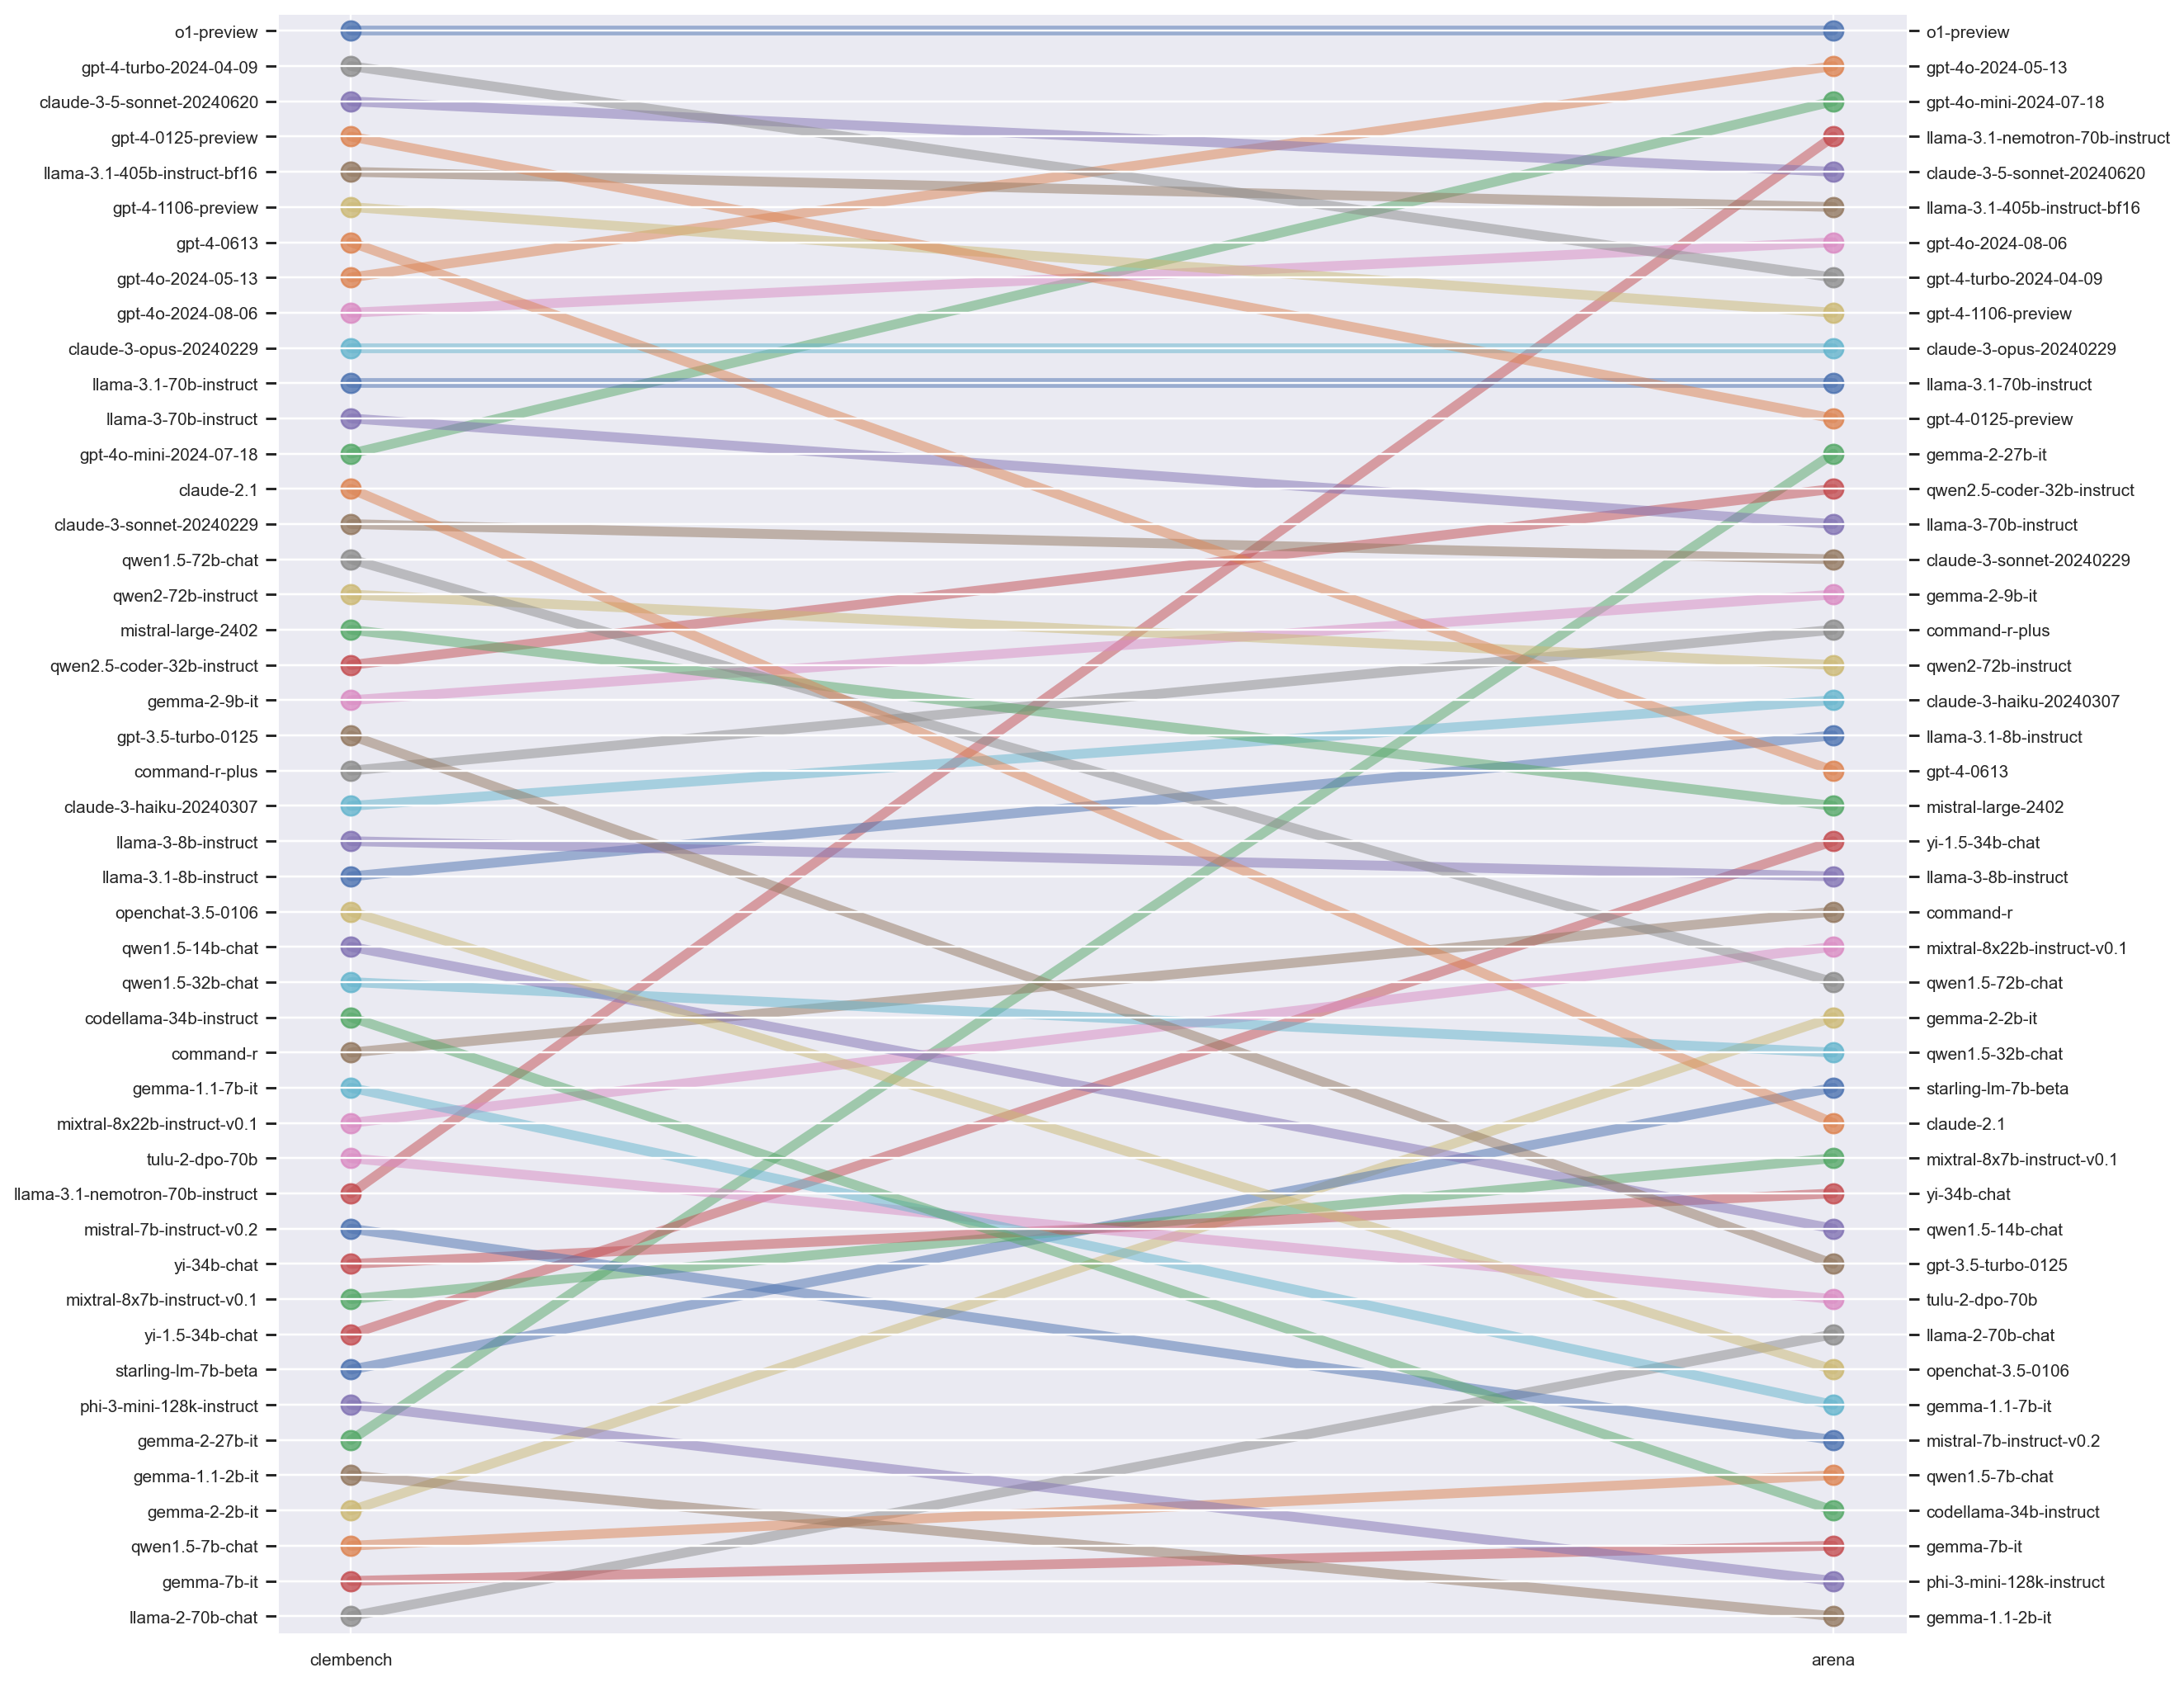

In [31]:
plt.figure(figsize=(15, 15))
bumpchart(comparison_arena_df.transpose(), **plot_params)
plt.show()

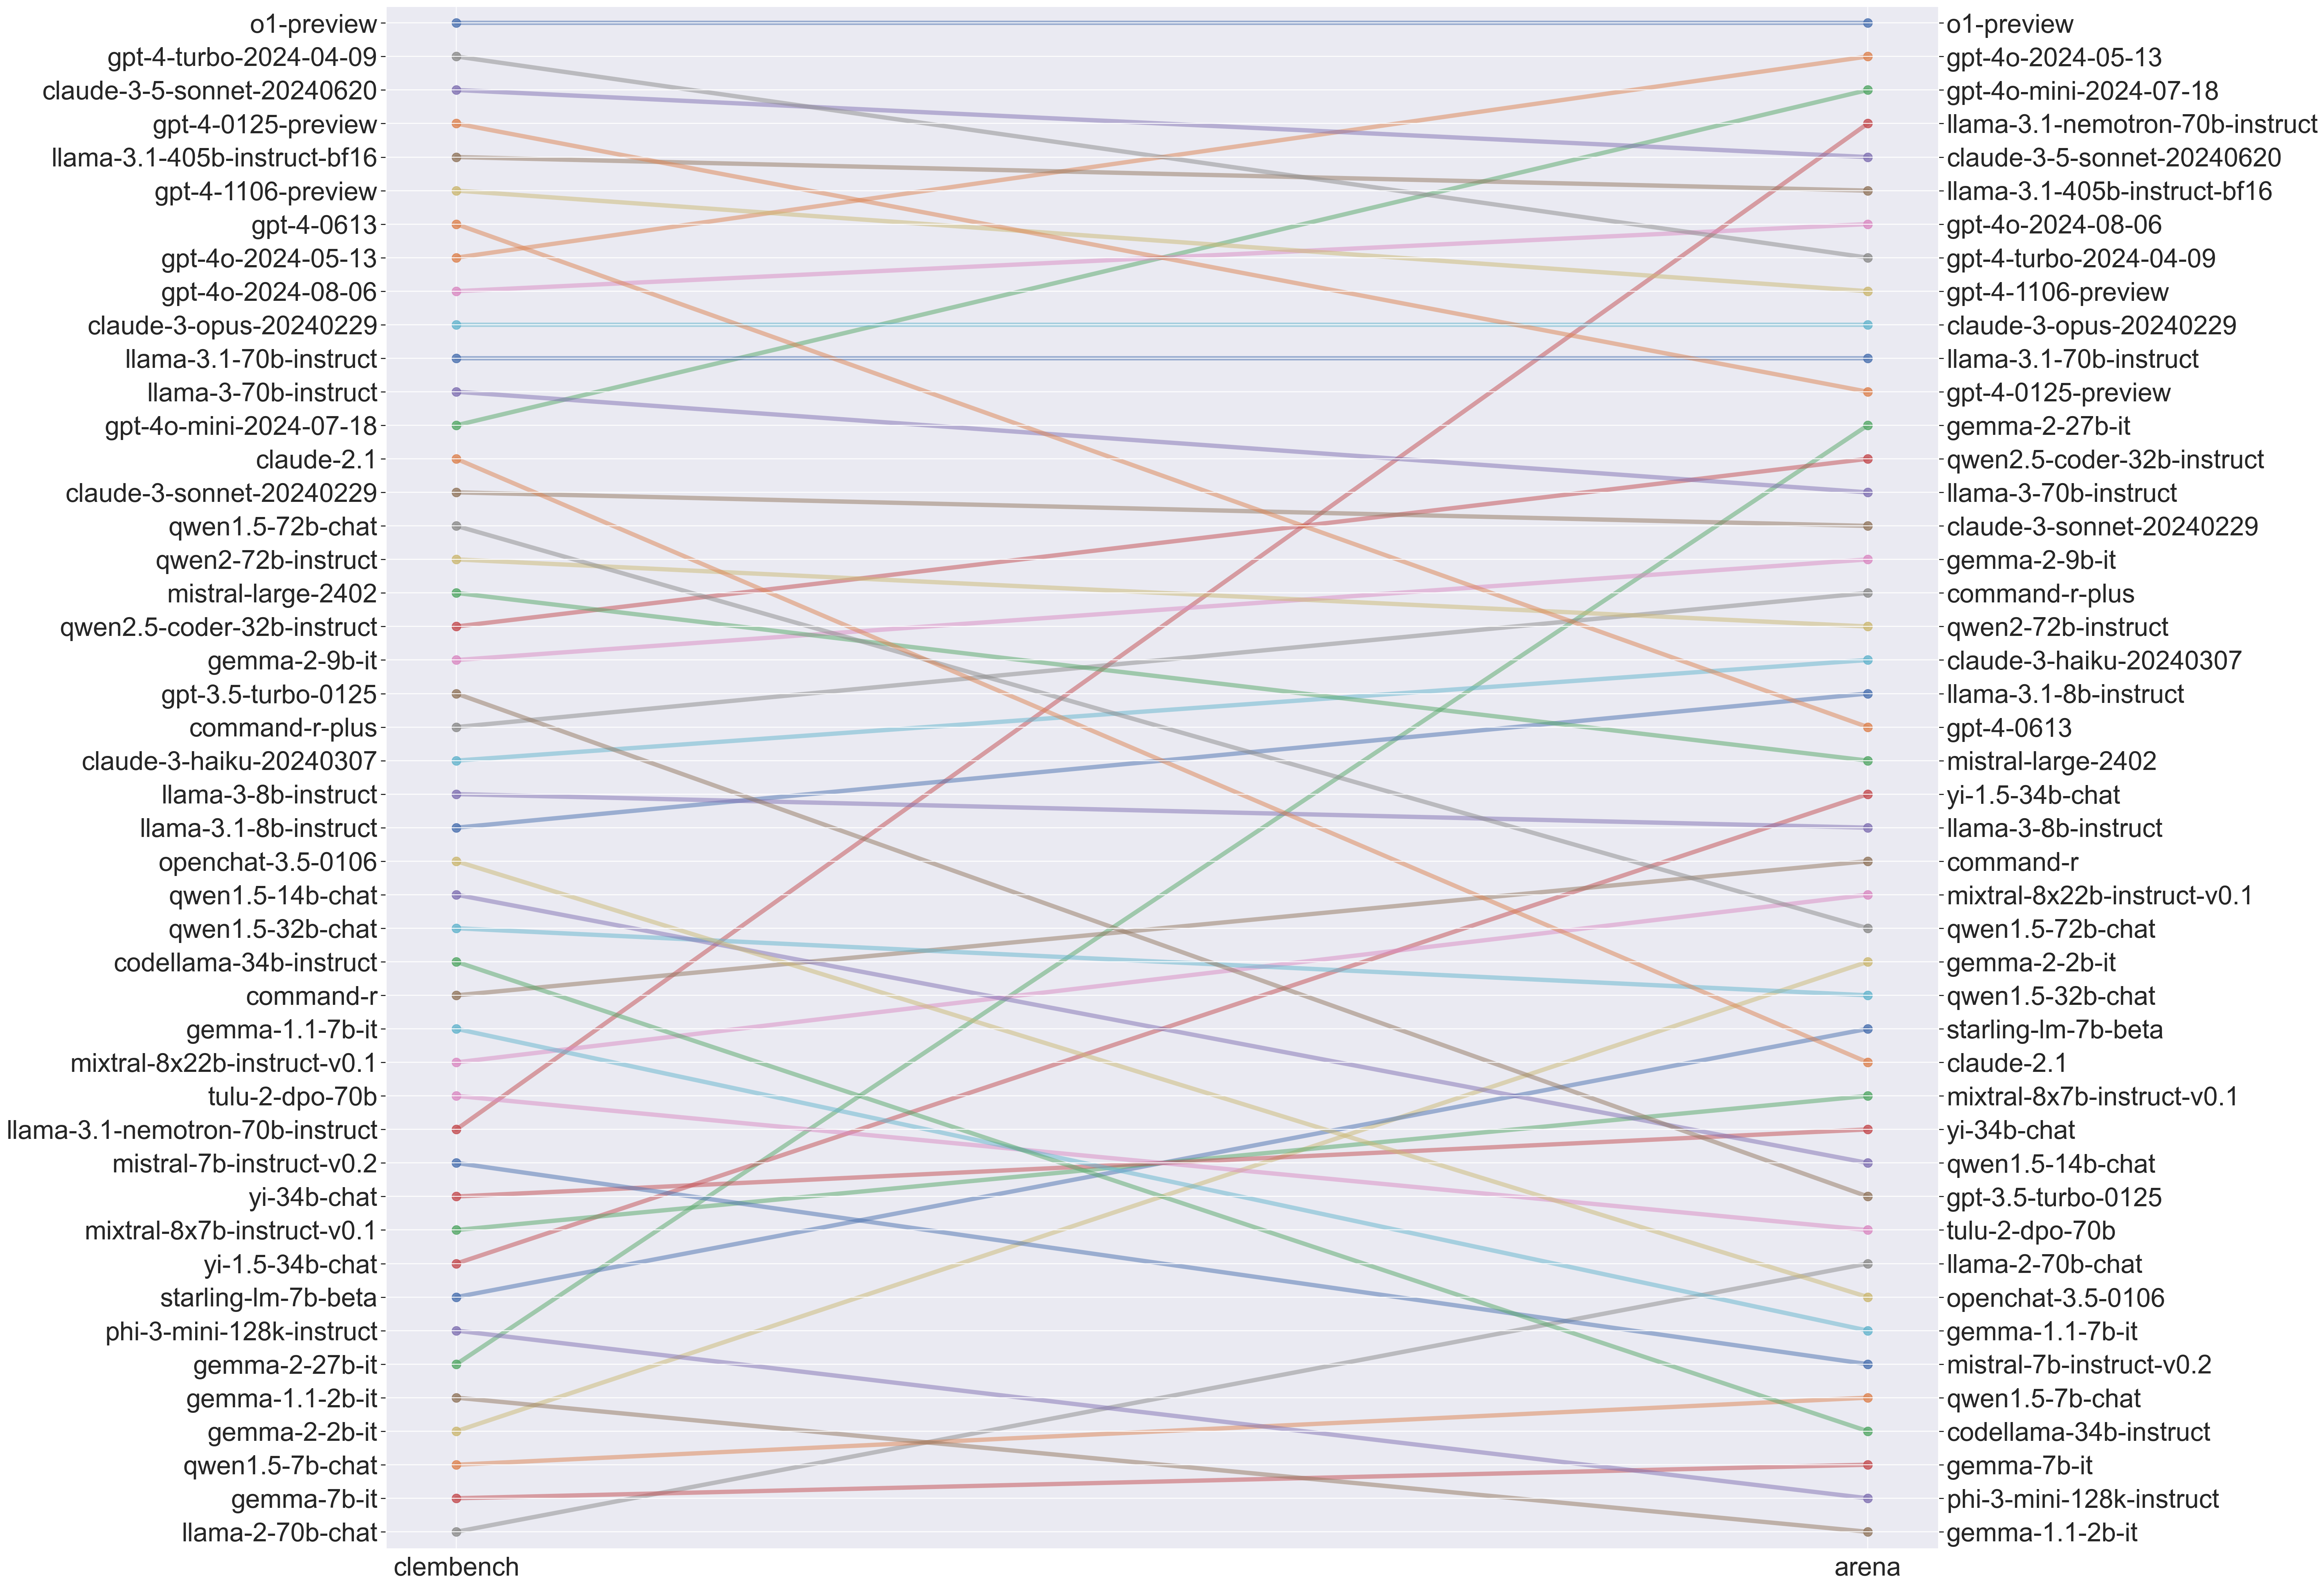

In [32]:
plt.figure(figsize=(32, 32))
axes = bumpchart(comparison_arena_df.transpose(), **plot_params)
axes[0].tick_params(labelsize=30)
axes[1].tick_params(labelsize=30)
plt.savefig(output_dir / 'clemb_arena_bump.png', bbox_inches='tight')
plt.show()

### HELM

first tried downloading from `https://storage.googleapis.com/crfm-helm-public/lite/benchmark_output/releases/v1.1.0/groups/core_scenarios.json`
as described in their documentation.... 

but that didn't go anywhere. (Check old version of this notebook for code.)

Haha. Crazy high-tech.. Go to: https://crfm.stanford.edu/helm/lite/v1.3.0/#/leaderboard , copy the fucking page, and paste it into excel...

That gives me a useable file format, but still only these useless model names... 

ok, same trick with https://crfm.stanford.edu/helm/lite/v1.3.0/#/models  which has the mapping

In [33]:
helm_results = pd.read_excel(data_dir / 'helm_results_v1.11.0.xlsx')
helm_models = pd.read_excel(data_dir / 'helm_models_list_v1.11.0.xlsx', header=None)

In [34]:
model_entries = helm_models.iloc[:,0].tolist()

In [35]:
helm_model_map = pd.Series(
    data=[re.sub(r'.*?/(.+)$', r'\1', entry.split('\n')[1]) for entry in model_entries],
    index=[entry.split('\n')[0] for entry in model_entries]
).to_dict()

In [36]:
helm_model_map

{'Jurassic-2 Grande (17B)': 'j2-grande',
 'Jurassic-2 Jumbo (178B)': 'j2-jumbo',
 'Jamba Instruct': 'jamba-instruct',
 'Jamba 1.5 Mini': 'jamba-1.5-mini',
 'Jamba 1.5 Large': 'jamba-1.5-large',
 'Luminous Base (13B)': 'luminous-base',
 'Luminous Extended (30B)': 'luminous-extended',
 'Luminous Supreme (70B)': 'luminous-supreme',
 'Claude v1.3': 'claude-v1.3',
 'Claude Instant 1.2': 'claude-instant-1.2',
 'Claude 2.0': 'claude-2.0',
 'Claude 2.1': 'claude-2.1',
 'Claude 3 Haiku (20240307)': 'claude-3-haiku-20240307',
 'Claude 3 Sonnet (20240229)': 'claude-3-sonnet-20240229',
 'Claude 3 Opus (20240229)': 'claude-3-opus-20240229',
 'Claude 3.5 Sonnet (20240620)': 'claude-3-5-sonnet-20240620',
 'Claude 3.5 Sonnet (20241022)': 'claude-3-5-sonnet-20241022',
 'Command': 'command',
 'Command Light': 'command-light',
 'Command R': 'command-r',
 'Command R Plus': 'command-r-plus',
 'DBRX Instruct': 'dbrx-instruct',
 'DeepSeek LLM Chat (67B)': 'deepseek-llm-67b-chat',
 'Gemini 1.0 Pro (002)': 'ge

In [37]:
helm_df = helm_results.iloc[:, [0,1]].copy(deep=True)
helm_df.columns = ['model', 'score']

In [38]:
helm_df.loc[:, 'model'] = helm_df.model.map(helm_model_map)
helm_df = helm_df.set_index('model')

In [39]:
helm_model_rankings = helm_df.score.rank(ascending=False)
helm_model_rankings

model
gpt-4o-2024-05-13              1.0
gpt-4o-2024-08-06              2.0
claude-3-5-sonnet-20240620     3.0
gpt-4-0613                     4.0
gpt-4-turbo-2024-04-09         5.0
                              ... 
command-light                 81.0
luminous-extended             82.0
falcon-7b                     83.0
olmo-7b                       84.0
luminous-base                 85.0
Name: score, Length: 85, dtype: float64

### Clembench, ChatBot Arena -- Intersect & Compare

In [40]:
clemb_helm = clemb.copy(deep=True)

In [41]:
clemb_helm.index = clemb_helm.index.map(
    lambda x: re.sub(
        r'(-hf)', '', 
        re.sub(r'(-chat)|(-it)', '', x)
    ).lower()
)

In [42]:
clemb_helm_intersect = set(clemb_helm.index).intersection(set(helm_df.index))

In [43]:
clemb_helm_intersect

{'claude-2.1',
 'claude-3-5-sonnet-20240620',
 'claude-3-haiku-20240307',
 'claude-3-opus-20240229',
 'claude-3-sonnet-20240229',
 'command-r',
 'command-r-plus',
 'gemma-7b',
 'gpt-4-0613',
 'gpt-4-1106-preview',
 'gpt-4-turbo-2024-04-09',
 'gpt-4o-2024-05-13',
 'gpt-4o-2024-08-06',
 'gpt-4o-mini-2024-07-18',
 'llama-2-70b',
 'llama-3.1-405b-instruct-turbo',
 'mistral-large-2402',
 'mistral-medium-2312',
 'qwen1.5-14b',
 'qwen1.5-32b',
 'qwen1.5-72b',
 'qwen1.5-7b',
 'qwen2-72b-instruct',
 'yi-34b'}

In [44]:
clemb_helm_ranks = clemb_helm[clemb_helm.index.isin(clemb_helm_intersect)][score_col].rank(ascending=False)
helm_ranks = helm_df[helm_df.index.isin(clemb_helm_intersect)]['score'].rank(ascending=False)

In [45]:
clemb_helm_ranks = clemb_helm_ranks.loc[helm_ranks.index]

In [46]:
helm_correlation, helm_p_value = stats.kendalltau(clemb_helm_ranks, helm_ranks)
helm_correlation, helm_p_value

(np.float64(0.5217391304347826), np.float64(0.00021637889669903591))

### Plot

In [47]:
comparison_helm_df = pd.DataFrame()
comparison_helm_df['clembench'] = clemb_helm_ranks.values
comparison_helm_df.index = clemb_helm_ranks.index
comparison_helm_df['helm'] = helm_ranks.loc[clemb_helm_ranks.index]

In [48]:
plot_params = {
    'show_rank_axis': False,
    'scatter': True,
    'holes': False,
    'line_args': {"linewidth": 5, "alpha": 0.5},
    'scatter_args': {"s": 100, "alpha": 0.8}
}

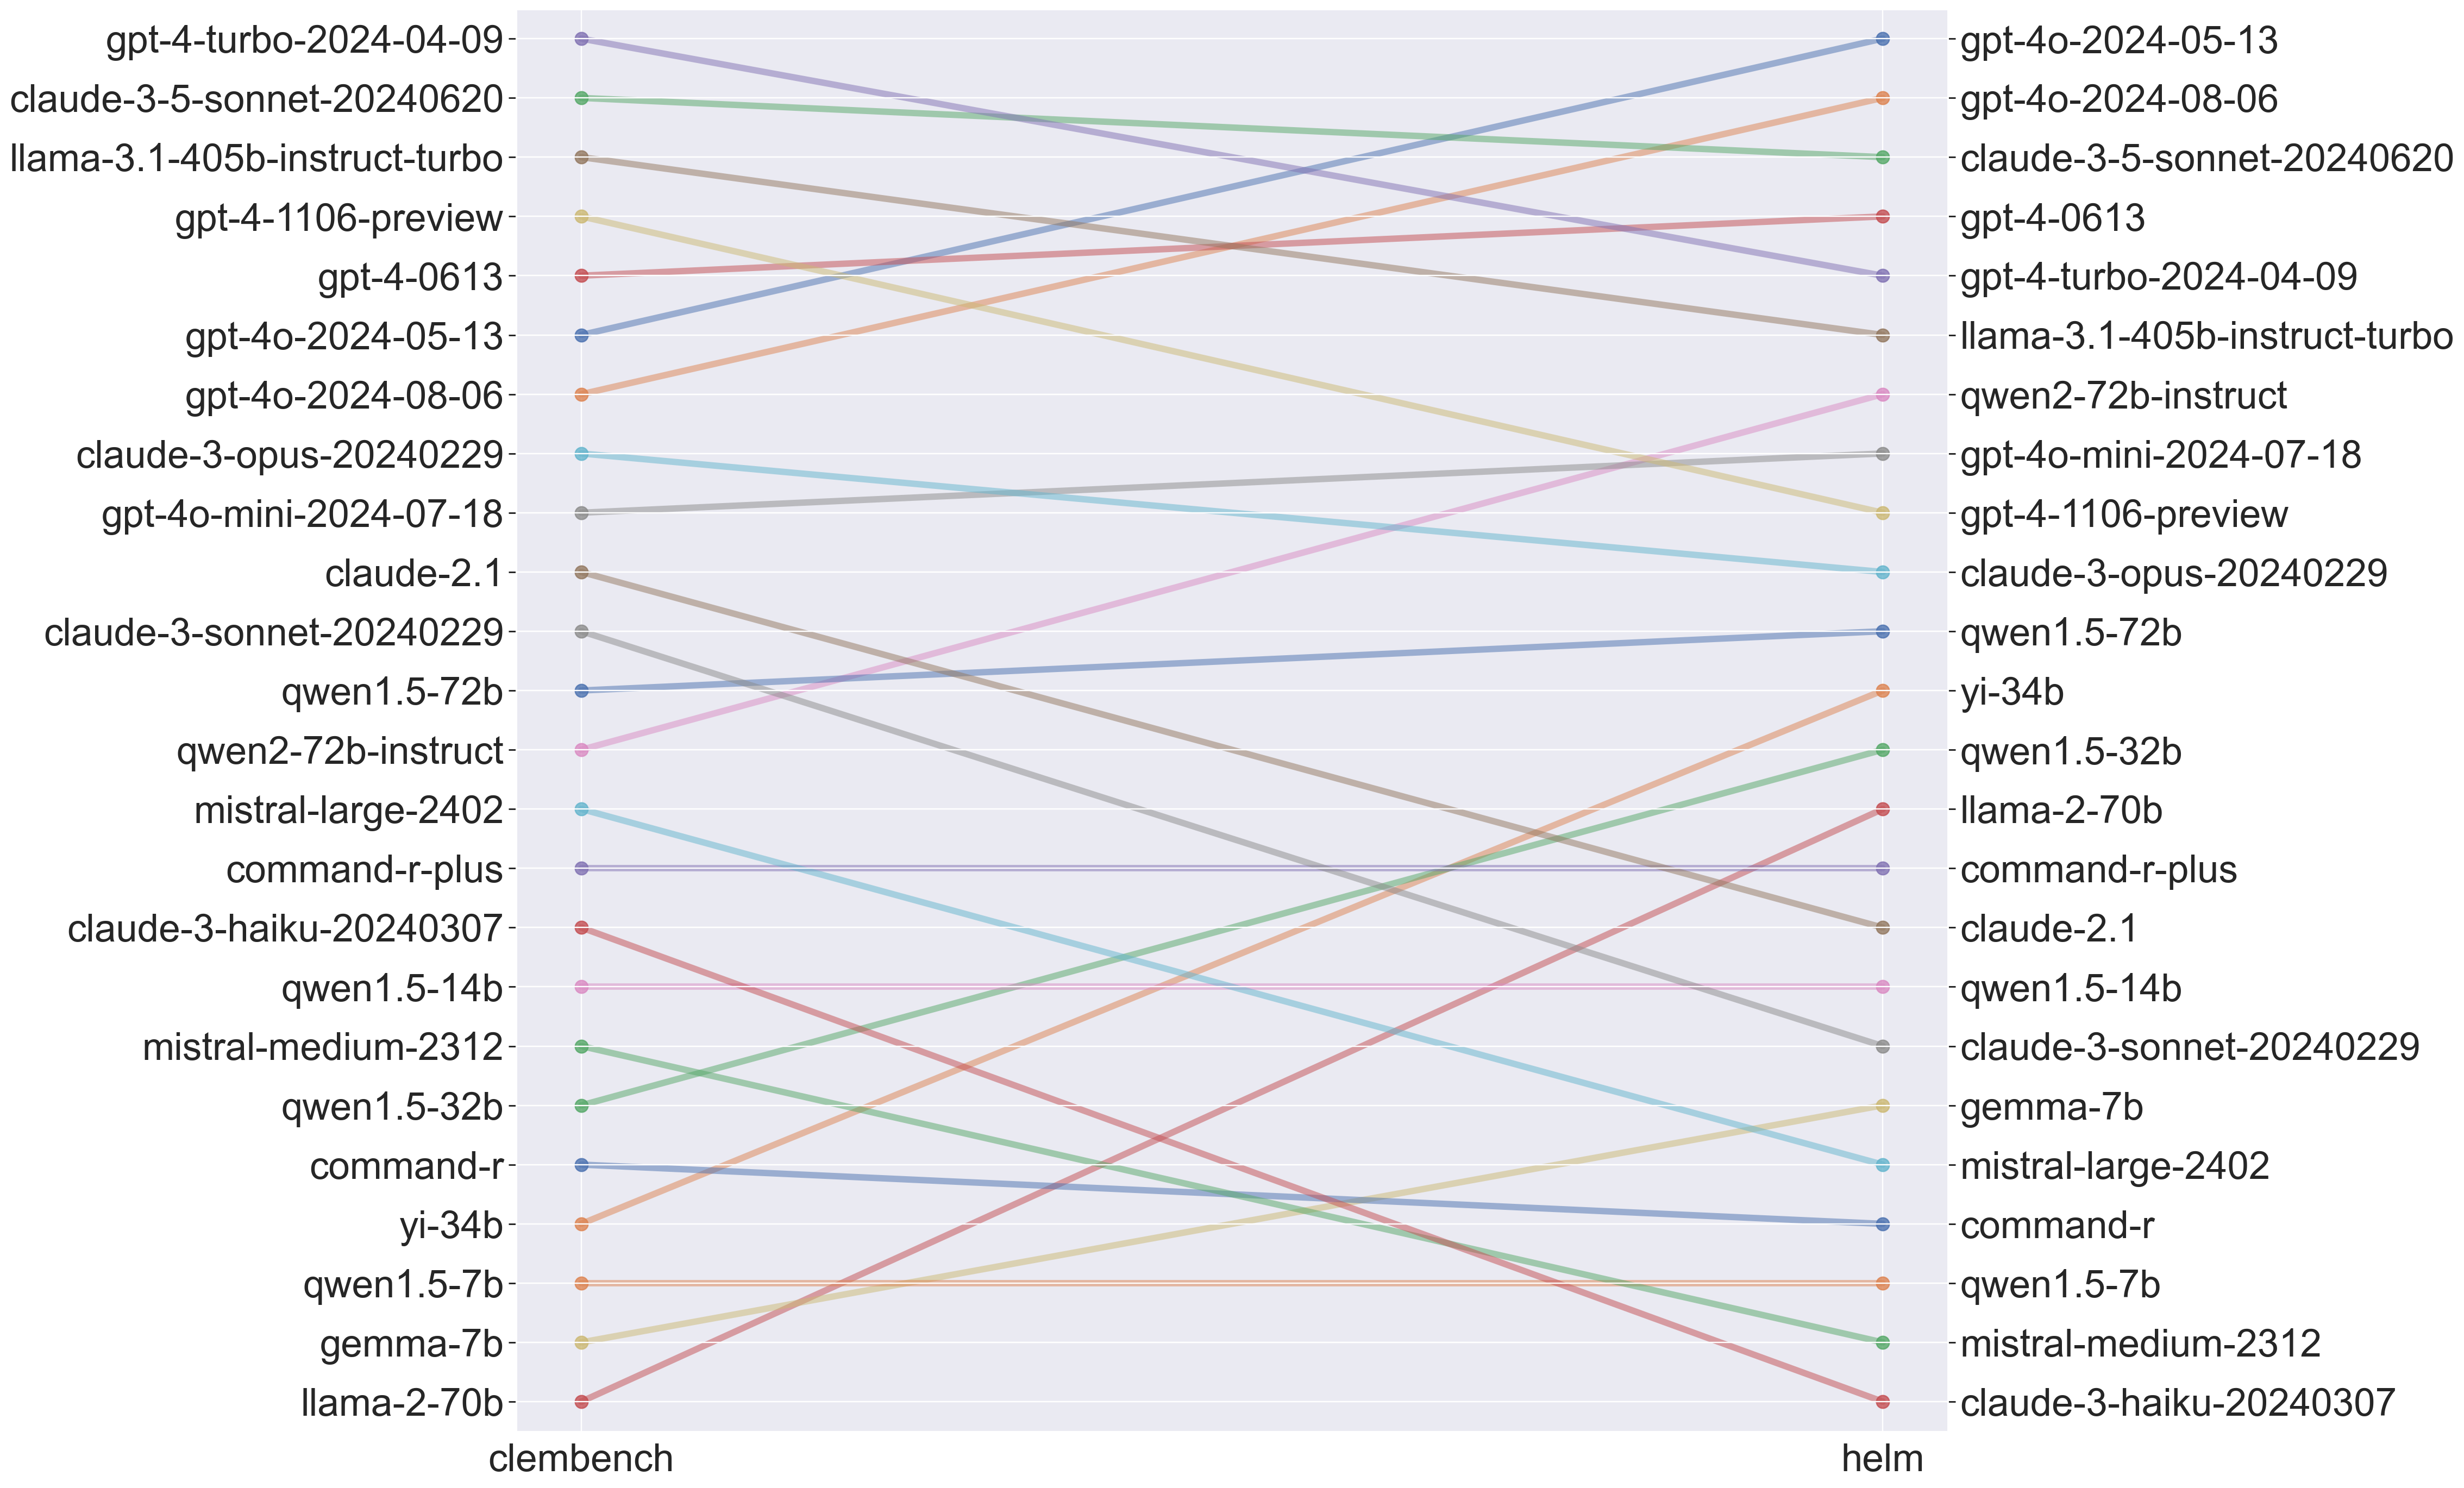

In [51]:
plt.figure(figsize=(20, 20))
axes = bumpchart(comparison_helm_df.transpose(), **plot_params)
axes[0].tick_params(labelsize=30)
axes[1].tick_params(labelsize=30)
plt.savefig(output_dir / 'clemb_helm_bump.png', bbox_inches='tight')
plt.show()

In [229]:
# problems 

In [ ]:
# Helm 
# 1. llama-3.1-8b -- clemb
# 1. llama-3.1-8b-Instruct-Turbo -- helm
# 2. llama-3.1-70b -- clemb
# 2. llama-3.1-70b-Instruct-Turbo -- helm